# ScV6Sn6 with X-TEC

In [1]:
import glob
import os
import time
import importlib
from scipy import ndimage


import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import numpy as np

import h5py  
import sys
sys.path.append('/share/kim/XTEC/src/xtec')
from scipy.ndimage import gaussian_filter

In [2]:
import os
os.getcwd()

'/home/kmm537/XTEC_notebooks/Kagome_2023_Data/ScV6Sn6/arxiv'

In [3]:
import multiprocessing as mp
print(mp.cpu_count())

40




##  Required XTEC modules 

The following modules are required for the XTEC analysis:



In [4]:
from Preprocessing import Mask_Zeros              # to remove zero intensity points from data       
from Preprocessing import Threshold_Background    # for thresholding background intensity

from sklearn.mixture import GaussianMixture   # for GMM clustering



# Step A. Import the XRD Data



In [5]:
import os

arr = os.listdir('/share/kim/STEM_Xray_data/Kagome_xray_SWilson/ScV6Sn6/wilson-3561-a_ScV6Sn6_sample3')

import regex as re
match_str='_T_(.*?)K.nxs'
Tlist=np.sort([int(re.findall(match_str,i)[0]) for i in arr ])
Tlist=Tlist[2:-1] # first 2 and last temperatures are off
num_T=len(Tlist)


In [6]:

print('Temperatures (K) =',Tlist)

Temperatures (K) = [ 45  50  55  60  65  70  80  82  84  86  88  90  92  94  96  98 100 105
 110 115 120 125 150 175 200 250]


In [7]:

Tnames = []
for T in Tlist:
    Tsplit = str(T).split('.')
    if len(Tsplit) > 1:
        Tnames.append(Tsplit[0] + 'p' + Tsplit[1])
    else:
        Tnames.append(Tsplit[0])

filepaths = ['/share/kim/STEM_Xray_data/Kagome_xray_SWilson/ScV6Sn6/wilson-3561-a_ScV6Sn6_sample3/3rot_hkli_T_'+T+'K.nxs' for T in Tnames] # list of file paths


doc = h5py.File(filepaths[0], 'r')
    
Qh=np.array(doc['entry/data']['H'])
Qk=np.array(doc['entry/data']['K'])
Ql=np.array(doc['entry/data']['L'])

delta_Qh=Qh[1]-Qh[0]
delta_Qk=Qk[1]-Qk[0]
delta_Ql=Ql[1]-Ql[0]


doc.close()


print(Qh.shape,Qk.shape,Ql.shape)
print('Ql=',Ql[0],' to ',Ql[-1],np.round(delta_Ql,3))
print('Qk=',Qk[0],' to ', Qk[-1],np.round(delta_Qk,3))
print('Qh=', Qh[0],' to ', Qh[-1],np.round(delta_Qh,3))


(1020,) (1020,) (910,)
Ql= -9.1  to  9.08 0.02
Qk= -5.1  to  5.09 0.01
Qh= -5.1  to  5.09 0.01


# Get Bragg indices and Brillouin zone size

In [8]:
x=abs(Qh-np.round(Qh))-0.5*delta_Qh
H_Bragg_ind=np.where(x<0)[0]

x=abs(Qk-np.round(Qk))-0.5*delta_Qk
K_Bragg_ind=np.where(x<0)[0]


x=abs(Ql-np.round(Ql))-0.5*delta_Ql
L_Bragg_ind=np.where(x<0)[0]


Qh_Bragg=Qh[H_Bragg_ind]
Qk_Bragg=Qk[K_Bragg_ind]
Ql_Bragg=Ql[L_Bragg_ind]

print('Qh Bragg', np.round(Qh_Bragg,3))
print('Qk Bragg', np.round(Qk_Bragg,3))
print('Ql_Bragg', np.round(Ql_Bragg,3))


cell_start_ind=[(p,q,r)  for p in H_Bragg_ind[0:-1] for q in K_Bragg_ind[0:-1] for r in L_Bragg_ind[0:-1]] 

cell_size=(int(H_Bragg_ind[1]-H_Bragg_ind[0]),int(K_Bragg_ind[1]-K_Bragg_ind[0]),int(L_Bragg_ind[1]-L_Bragg_ind[0]))
print('unit cell size (#H,#K,#L)=', cell_size)

num_cells=len(cell_start_ind)
print('num of cells=', num_cells )



Qh Bragg [-5. -4. -3. -2. -1. -0.  1.  2.  3.  4.  5.]
Qk Bragg [-5. -4. -3. -2. -1. -0.  1.  2.  3.  4.  5.]
Ql_Bragg [-9. -8. -7. -6. -5. -4. -3. -2. -1. -0.  1.  2.  3.  4.  5.  6.  7.  8.
  9.]
unit cell size (#H,#K,#L)= (100, 100, 50)
num of cells= 1800


# set sigma of Gaussian smoothing

In [16]:
sig=(0,0.5,0.5,0.5)  #(T,H,K,L)


In [17]:
def Extract_smooth_unit_cell_data(sig, cpu_counter):
    
    data_slice={}
    smooth_window= (int(4*sig[1]), int(4*sig[2]), int(4*sig[3]))     

    
    unit_start=cell_start_ind[cpu_counter]

    if (((unit_start[0]+cell_size[0])>=len(Qh)) or 
        ((unit_start[1]+cell_size[1])>=len(Qk)) or 
        ((unit_start[2]+cell_size[2])>=len(Ql))):
            print('wrong cell shape')
            return None
    
    
    
    #get min and max indices of enlarged cell 
    h_min=max(0,unit_start[0]-smooth_window[0])
    k_min=max(0,unit_start[1]-smooth_window[1])
    l_min=max(0,unit_start[2]-smooth_window[2])

    h_max=min(len(Qh)-1,unit_start[0]+cell_size[0]+smooth_window[0])
    k_max=min(len(Qk)-1,unit_start[1]+cell_size[1]+smooth_window[1])
    l_max=min(len(Ql)-1,unit_start[2]+cell_size[2]+smooth_window[2])

    
    
    Qh_cell=Qh[h_min:h_max]
    Qk_cell=Qk[k_min:k_max]
    Ql_cell=Ql[l_min:l_max]



    # read data from this cell
    data = []
    num_T=len(filepaths)
    for filepath in filepaths:
        doc = h5py.File(filepath, 'r')
        dataT = doc['entry/data/counts'][h_min:h_max,k_min:k_max,l_min:l_max]
        data.append(dataT)
        doc.close()
    I = np.squeeze(data)   
    
    if (np.amax(I)  < 1):
        return data_slice  # skip empty slices
    
    I= gaussian_filter(I,sig)

    #get min and max indices unit cell inside this enlarged cell 
    h_min=max(0,smooth_window[0])
    k_min=max(0,smooth_window[1])
    l_min=max(0,smooth_window[2])

    h_max=min(I.shape[1],cell_size[0]+smooth_window[0])
    k_max=min(I.shape[2],cell_size[1]+smooth_window[1])
    l_max=min(I.shape[3],cell_size[2]+smooth_window[2])

    
    
    Qh_cell=Qh_cell[h_min:h_max]
    Qk_cell=Qk_cell[k_min:k_max]
    Ql_cell=Ql_cell[l_min:l_max]
    
    # clip down I to the unit cell
    I=I[:,h_min:h_max,k_min:k_max,l_min:l_max]
    
    try:
        masked    = Mask_Zeros(I)
        threshold = Threshold_Background(masked)
        num_thresholded  = threshold.data_thresholded.shape[1]
        if num_thresholded  == 0:
            return data_slice
    except:
        return data_slice   # if thresholding failed for this unit cell
    
    
    
    
    max_num_features = 5000
    sector_id=int(cpu_counter)*max_num_features
    
    structure_element = np.ones((3,3,3))    # to identify features if they are connected, even diagonally
    labeled_array, num_features = ndimage.label(threshold.thresholded,structure=structure_element)
                    # threshold.thresholded :  non_zero data(h,k,l)=1 if above cutoff 
                    # labelled_array(h,k,l) has connected features (#num_features) marked by different integers 
    labels= list(range(1,num_features+1))
    
    if(num_features>max_num_features):
        print('num features too large', num_features,max_num_features)
        return 
    
    
    # remove Bragg peaks
    
    #finding Bragg labels
    Bragg_inds = [(i,j,k) for i in [0,cell_size[0]-1] for j in [0,cell_size[1]-1] for k in [0,cell_size[2]-1]]
    Bragg_labels = [labeled_array[ind] for ind in Bragg_inds]   # labels at Brag_loc
    Bragg_labels = np.unique(Bragg_labels)

    # non bragg labels
    Non_Bragg_labels=np.setdiff1d(labels,Bragg_labels+[0])
    Non_Bragg_labels = np.unique(Non_Bragg_labels)

    NonBragg_mask = np.isin(labeled_array,Non_Bragg_labels)           # returns true for labeled arrays that match  NonBragg_labels
    NonBragg_ind  = np.array(np.where(NonBragg_mask)).transpose()    # h,k,l indices of non Bragg data, (#non_Bragg_data, 3) 
    
    # number of non bragg peaks
    num_NB= len(Non_Bragg_labels)
    # now for each peak (connected set of pixels) find peak avg, max, tot, and indices of pixels in the peak
    peak_avg = np.zeros((num_NB,num_T))       # peak averaged non bragg int, shape=(num_T, num_NB)
    peak_tot = np.zeros((num_NB,num_T))
    peak_max = np.zeros((num_NB,num_T))
    
    ind_in_peak={} #the hkl indices of all pixels in a peak 
    data_in_peak={} # intensity data of all pixels in a peak
     
    peak_label = np.zeros(num_NB) # labels of peak averaged non bragg intensities
    peak_COM   = np.zeros([num_NB,num_T,3])
    
    
    
    
        
    
    count=0
    for nbl in Non_Bragg_labels:
        mask_i  = np.isin(labeled_array,nbl)
        
        data_i  = I[:,mask_i]
        
        peak_tot[count,:] = np.sum(data_i, axis=1)   
        peak_avg[count,:] = np.mean(data_i, axis=1)  
        peak_max[count,:] = np.amax(data_i, axis=1)  
        
        
        peak_id = nbl+sector_id
        peak_label[count]   = peak_id      # label of the jth averaged Non Bragg data point, same as NonBragg_labels
        
        
        data_in_peak[peak_id]=data_i
        ind_i   = np.nonzero(mask_i)
        ind_in_peak[peak_id] = [ind_i[x]+unit_start[x] for x in [0,1,2]]
        
        
        
        for t in range(num_T):
            com=ndimage.center_of_mass(I[t]+0.001, labeled_array,nbl)
            h_com=(com[0]+unit_start[0])*(Qh[1]-Qh[0])+Qh[0]
            k_com=(com[1]+unit_start[1])*(Qk[1]-Qk[0])+Qk[0]
            l_com=(com[2]+unit_start[2])*(Ql[1]-Ql[0])+Ql[0]
            peak_COM[count,t,:]=np.array([h_com,k_com,l_com])
     
        count+=1

    data_slice['peak_avg'] = peak_avg
    data_slice['peak_tot'] = peak_tot
    data_slice['peak_max'] = peak_max
    
    data_slice['ind_in_peak']=ind_in_peak
    data_slice['data_in_peak']=data_in_peak
    
    
    data_slice['peak_label'] = peak_label
    
    data_slice['peak_COM']=peak_COM
    
    #print('Completed', cpu_counter)
    return data_slice
    
    

# Extract peaks from all brillouin zones (and remove Bragg peaks)

In [18]:
cpu_counter=range(num_cells)

start_time = time.time()

import multiprocessing as mp
from functools import partial   # partial functions like: func(x,y,z), par=partial(func,2,3) gives par(1)= func(2,3,1)  

Preprocessing = partial(Extract_smooth_unit_cell_data,sig)
print('num of cpus', 38)
#pool = mp.Pool(mp.cpu_count())
pool = mp.Pool(38) # Leave a couple prcs free
processed_data = pool.map(Preprocessing,cpu_counter)
run_time = time.time() - start_time
print("Total Run Time:",run_time)



num of cpus 38


/share/kim/XTEC/src/xtec/Preprocessing.py:345: RuntimeWarning: invalid value encountered in log
  DLogKL = (np.log(KL_div_plus_dx) - np.log(KL_div)) / self.bin_size
/share/kim/XTEC/src/xtec/Preprocessing.py:345: RuntimeWarning: invalid value encountered in log
  DLogKL = (np.log(KL_div_plus_dx) - np.log(KL_div)) / self.bin_size
/share/kim/XTEC/src/xtec/Preprocessing.py:345: RuntimeWarning: invalid value encountered in log
  DLogKL = (np.log(KL_div_plus_dx) - np.log(KL_div)) / self.bin_size


Total Run Time: 579.798938035965


Process ForkPoolWorker-16:
Process ForkPoolWorker-24:
Process ForkPoolWorker-20:
Process ForkPoolWorker-13:
Process ForkPoolWorker-21:
Process ForkPoolWorker-25:
Process ForkPoolWorker-12:
Process ForkPoolWorker-3:
Process ForkPoolWorker-38:
Process ForkPoolWorker-27:
Process ForkPoolWorker-34:
Process ForkPoolWorker-6:
Process ForkPoolWorker-22:
Process ForkPoolWorker-37:
Process ForkPoolWorker-2:
Process ForkPoolWorker-18:
Process ForkPoolWorker-1:
Process ForkPoolWorker-33:
Process ForkPoolWorker-4:
Process ForkPoolWorker-35:
Process ForkPoolWorker-10:
Process ForkPoolWorker-8:
Process ForkPoolWorker-36:
Process ForkPoolWorker-9:
Process ForkPoolWorker-7:
Process ForkPoolWorker-26:
Process ForkPoolWorker-29:
Process ForkPoolWorker-23:
Process ForkPoolWorker-17:
Process ForkPoolWorker-28:
Process ForkPoolWorker-5:
Process ForkPoolWorker-14:
Process ForkPoolWorker-32:
Process ForkPoolWorker-11:
Process ForkPoolWorker-19:
Process ForkPoolWorker-15:
Traceback (most recent call last):
Tr

In [19]:
import pickle
#pickle.dump( processed_data, open( "Smooth_0p5_processed_data_CDW_XTECD.p", "wb" ) )


# Load already extracted data

In [9]:
import pickle
processed_data = pickle.load(open( "Smooth_0p5_processed_data_CDW_XTECD.p", "rb" ) )


In [10]:
peak_avg_list = []
peak_tot_list = []
peak_max_list = []
peak_COM_list = []
peak_label_list = []

ind_in_peak={}
data_in_peak={}








for num, slices in enumerate(processed_data):
    if(bool(slices)):
        peak_avg_list.append(slices['peak_avg'])
        peak_tot_list.append(slices['peak_tot'])
        peak_max_list.append(slices['peak_max'])
        peak_COM_list.append(slices['peak_COM'])
        peak_label_list.append(slices['peak_label'])
        
        ind_in_peak.update(slices['ind_in_peak'])
        data_in_peak.update(slices['data_in_peak'])
        
        
peak_avg = np.vstack(peak_avg_list)  #(num_T, num_NB_data)
peak_tot = np.vstack(peak_tot_list)  #(num_T, num_NB_data)
peak_max = np.vstack(peak_max_list)  #(num_T, num_NB_data)
peak_COM = np.vstack(peak_COM_list)  #(num_T, num_NB_data)
peak_label=np.hstack(peak_label_list)


print(peak_avg.shape)
print(peak_tot.shape)
print(peak_max.shape)
print(peak_COM.shape)
print(peak_label.shape)

print(len(ind_in_peak))
print(len(data_in_peak))





(66992, 26)
(66992, 26)
(66992, 26)
(66992, 26, 3)
(66992,)
66992
66992


# XTEC D on all non-Bragg pixels

In [11]:

XTEC_D_data=[]
XTEC_D_ind=[]
for i in peak_label:
    XTEC_D_data.append(data_in_peak[i])
    XTEC_D_ind.append(ind_in_peak[i])

XTEC_D_data=np.hstack(XTEC_D_data)
XTEC_D_ind=np.hstack(XTEC_D_ind)

print(XTEC_D_data.shape)
print(XTEC_D_ind.shape)






(26, 3167261)
(3, 3167261)


In [13]:
x_train = np.array(Tlist)
data_post_thresh = (XTEC_D_data)
data_post_thresh_no_mean = (data_post_thresh-np.mean(data_post_thresh,axis=0))/(0.01+np.std(data_post_thresh,axis=0))
X=data_post_thresh_no_mean.transpose() 

print('Data shape',X.shape)


Data shape (3167261, 26)


In [14]:
n_clusters=3


In [15]:
gm = GaussianMixture(n_components=n_clusters,covariance_type='diag',init_params='kmeans',n_init=10).fit(X)


(3, 26)
(3, 26)
(3167261,)


In [16]:
import pickle
pickle.dump( {'gm':gm}, open( "XTECD_gm.p", "wb" ) )


# Visualize and interpret clusters

In [14]:
import pickle
obj=pickle.load(  open( "XTECD_gm.p", "rb" ) )
gm=obj['gm']   # loading the stored gmm model


cluster_assigns=gm.predict(X)
n_clusters=max(cluster_assigns)+1

cluster_means=gm.means_
cluster_covs=gm.covariances_


print(n_clusters)
print(cluster_means.shape)
print(cluster_covs.shape)
print(cluster_assigns.shape)


3
(3, 26)
(3, 26)
(3167261,)


In [42]:
color_list = ['firebrick', 'teal', 'gainsboro', 'purple', 'yellow', 'orange', 'pink', 'black', 'grey', 'cyan']

marker_list=['o','s',None]
line_list=['-','--',':']
lw_list=[4.5,4.5,4]


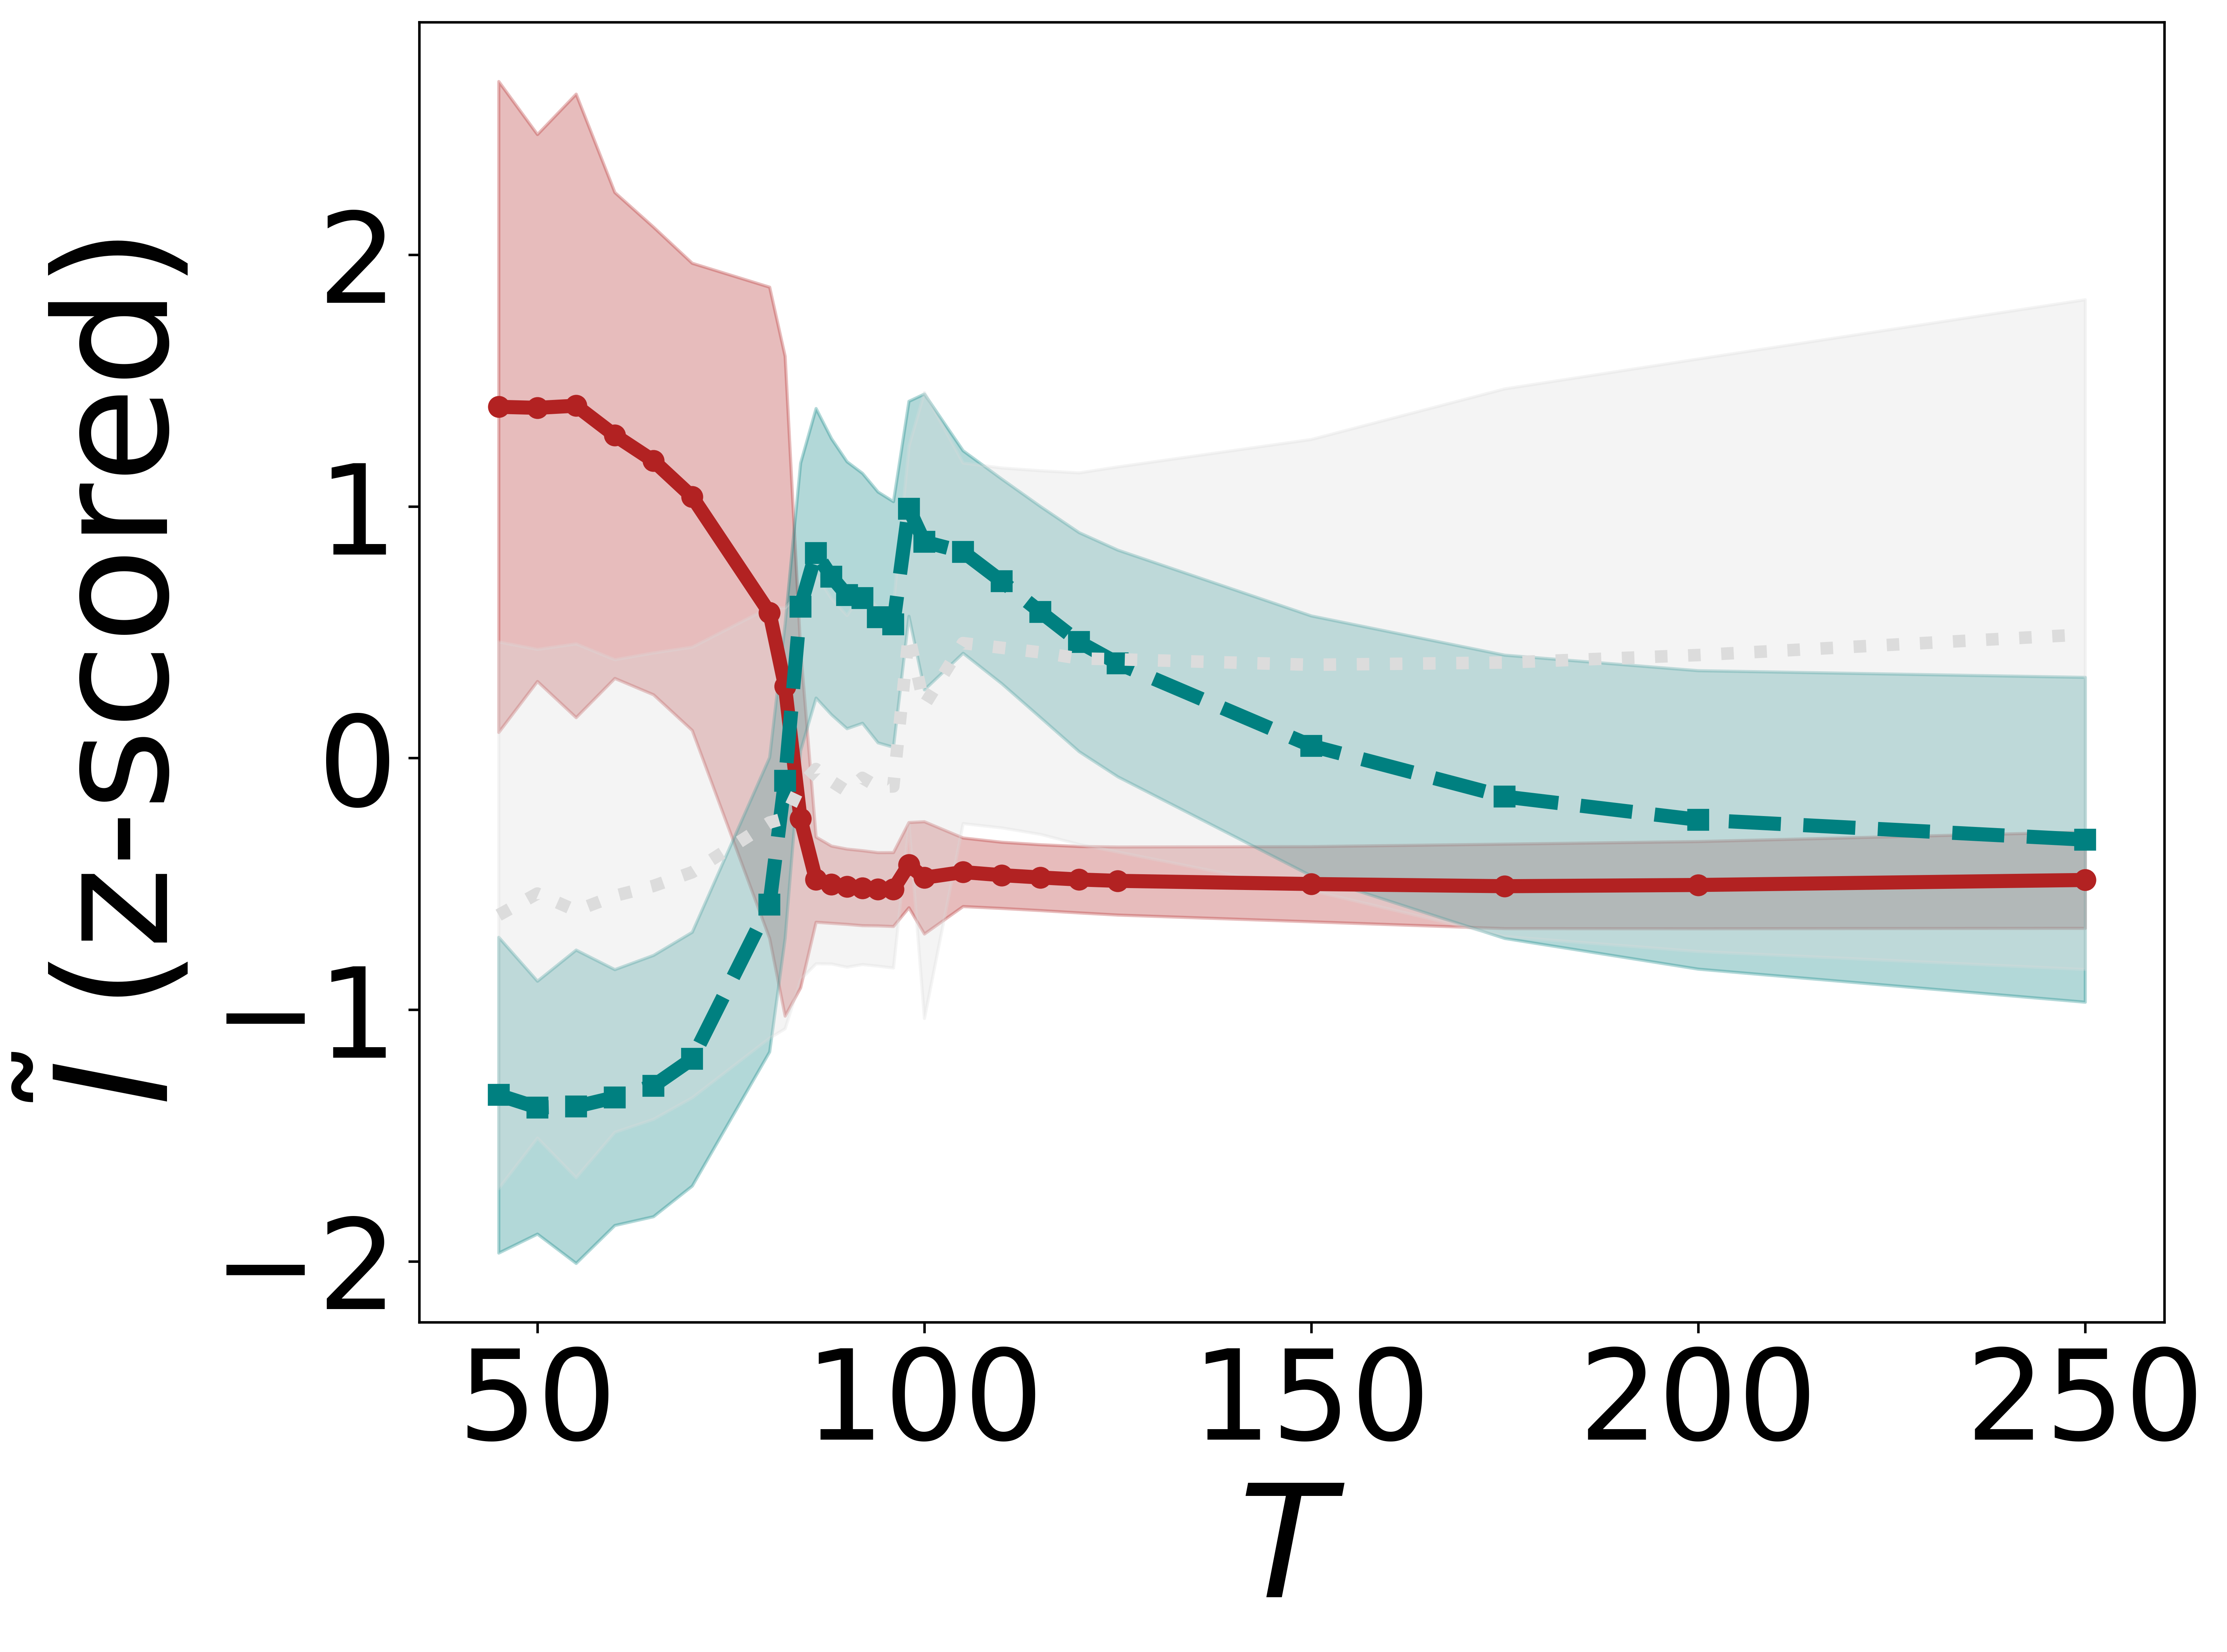

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7.5),dpi=600)
ax = plt.gca()




cluster_mean=[]
cluster_std=[]

for i in (range(n_clusters)):
    yc=cluster_means[i]
    yc_std=(cluster_covs[i])**0.5
    plt.plot(Tlist,yc,color=color_list[i], linestyle=line_list[i],marker=marker_list[i],lw=lw_list[i]);
    plt.gca().fill_between(Tlist,yc-yc_std,yc+ yc_std, color=color_list[i],alpha=0.3)
    
    cluster_mean.append(yc)    
    cluster_std.append(yc_std)

plt.xlabel(f'$T$',size=50)
plt.ylabel(r'$\tilde{I}$ (z-scored)',size=50)
#plt.title(r'Cluster mean and std',size=50)


#handles, labels = ax.get_legend_handles_labels()
#ax.legend(reversed(handles), reversed(labels),frameon=False, fontsize=16,ncol=2)

plt.xticks(size=40);
plt.yticks(size=40);





In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_Q_hist(ax_id):
    
    KDE_list=[True]*10
    if ax_id==0 :
        Q_ax=Qh
        
    if ax_id==1 :
        Q_ax=Qk
    if ax_id==2 :
        Q_ax=Ql
        KDE_list=[True,False,True]
        

    

    for i in range(n_clusters):
        cluster_mask_i = (cluster_assigns == i)
    
        yc=XTEC_D_ind[ax_id,cluster_mask_i]
        
        yc=Q_ax[yc]
        yc=yc-np.floor(yc)
        
        plt.figure()
        #sns.distplot(yc,  kde=True,norm_hist=True, color=color_list[i], kde_kws={'linewidth': 4})
        
        
        sns.histplot(data=yc, stat='probability',bins=40, kde=KDE_list[i],edgecolor=None, color=color_list[i],line_kws={'linewidth': 3})
    
        plt.yscale("linear")
        if ax_id==2:
            L_BZ[i]=yc
            plt.xlabel('L (reduced zone)',size=20)
        if ax_id==1:
            K_BZ[i]=yc
            plt.xlabel('K (reduced zone)',size=20)
        if ax_id==0:
            H_BZ[i]=yc
            plt.xlabel('H (reduced zone)',size=20)
        
        
        
        plt.ylabel('Pixel density',size=20)
        plt.xlim([0,1])
        plt.xticks([0,0.33,0.5,0.67,1],size=18)
        plt.ylim([0,0.15])
        plt.yticks(size=0)
    
        ax=plt.gca()
        ax.yaxis.grid(False) # Hide the horizontal gridlines
        ax.xaxis.grid(True)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))

        

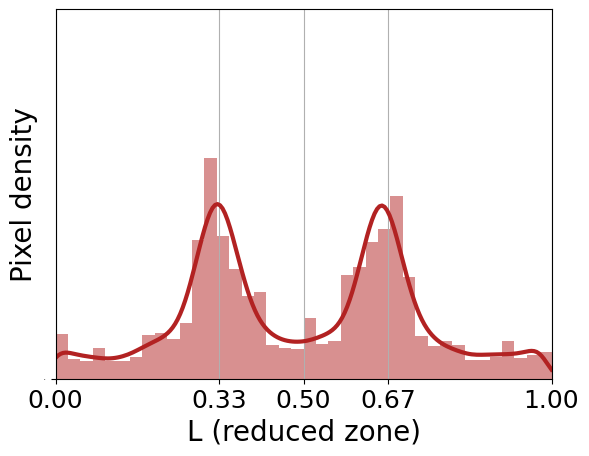

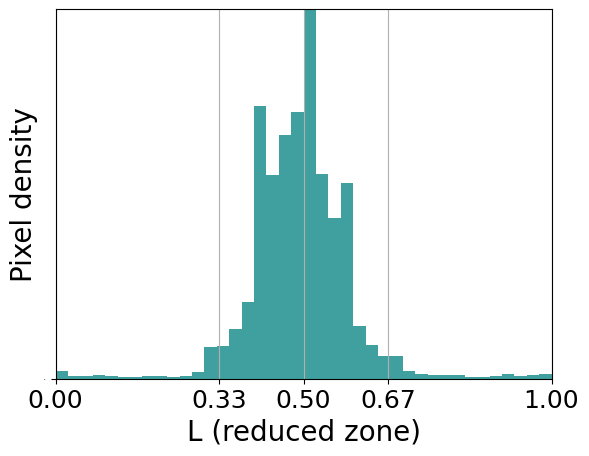

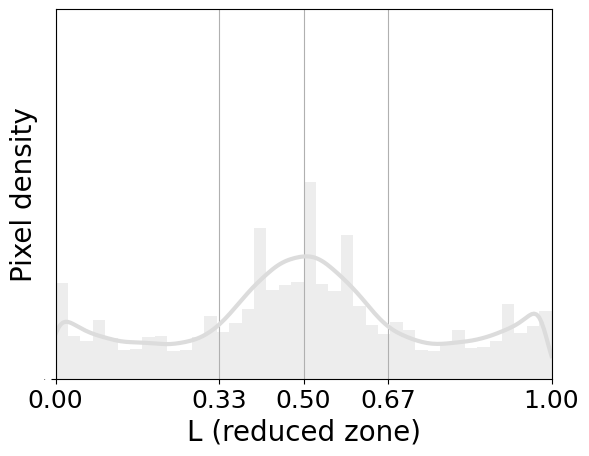

In [49]:
L_BZ={}
plot_Q_hist(2)

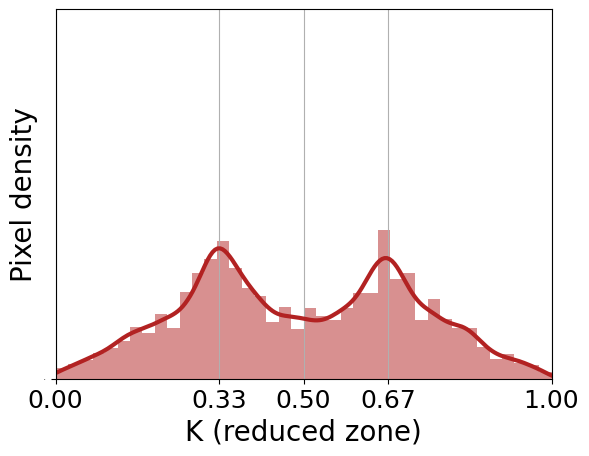

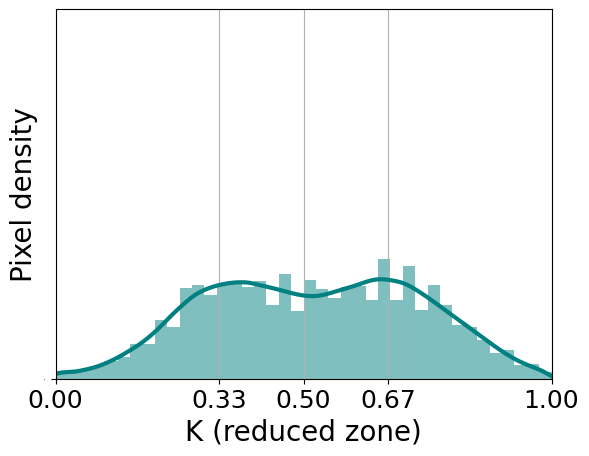

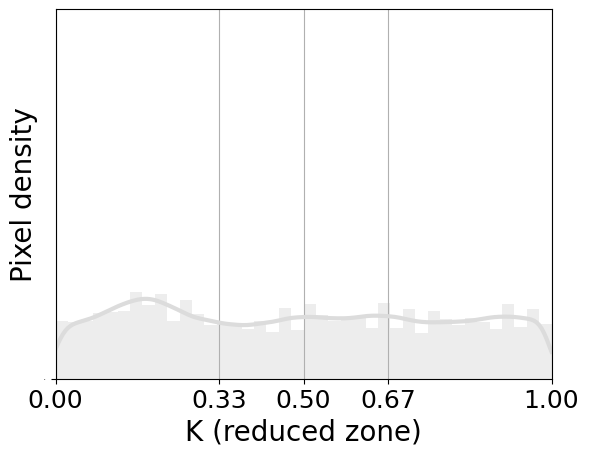

In [50]:
K_BZ={}
plot_Q_hist(1)

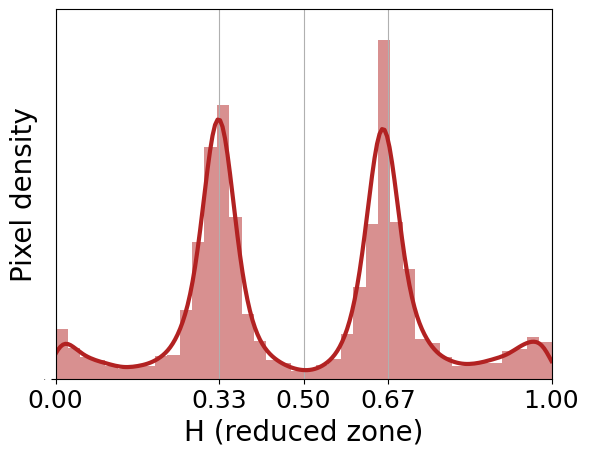

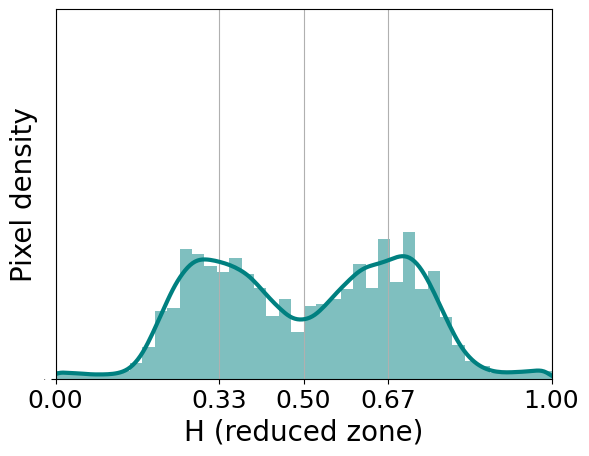

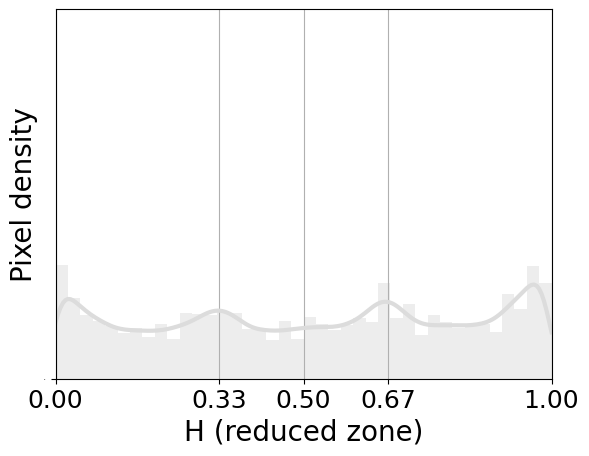

In [51]:
H_BZ={}
plot_Q_hist(0)

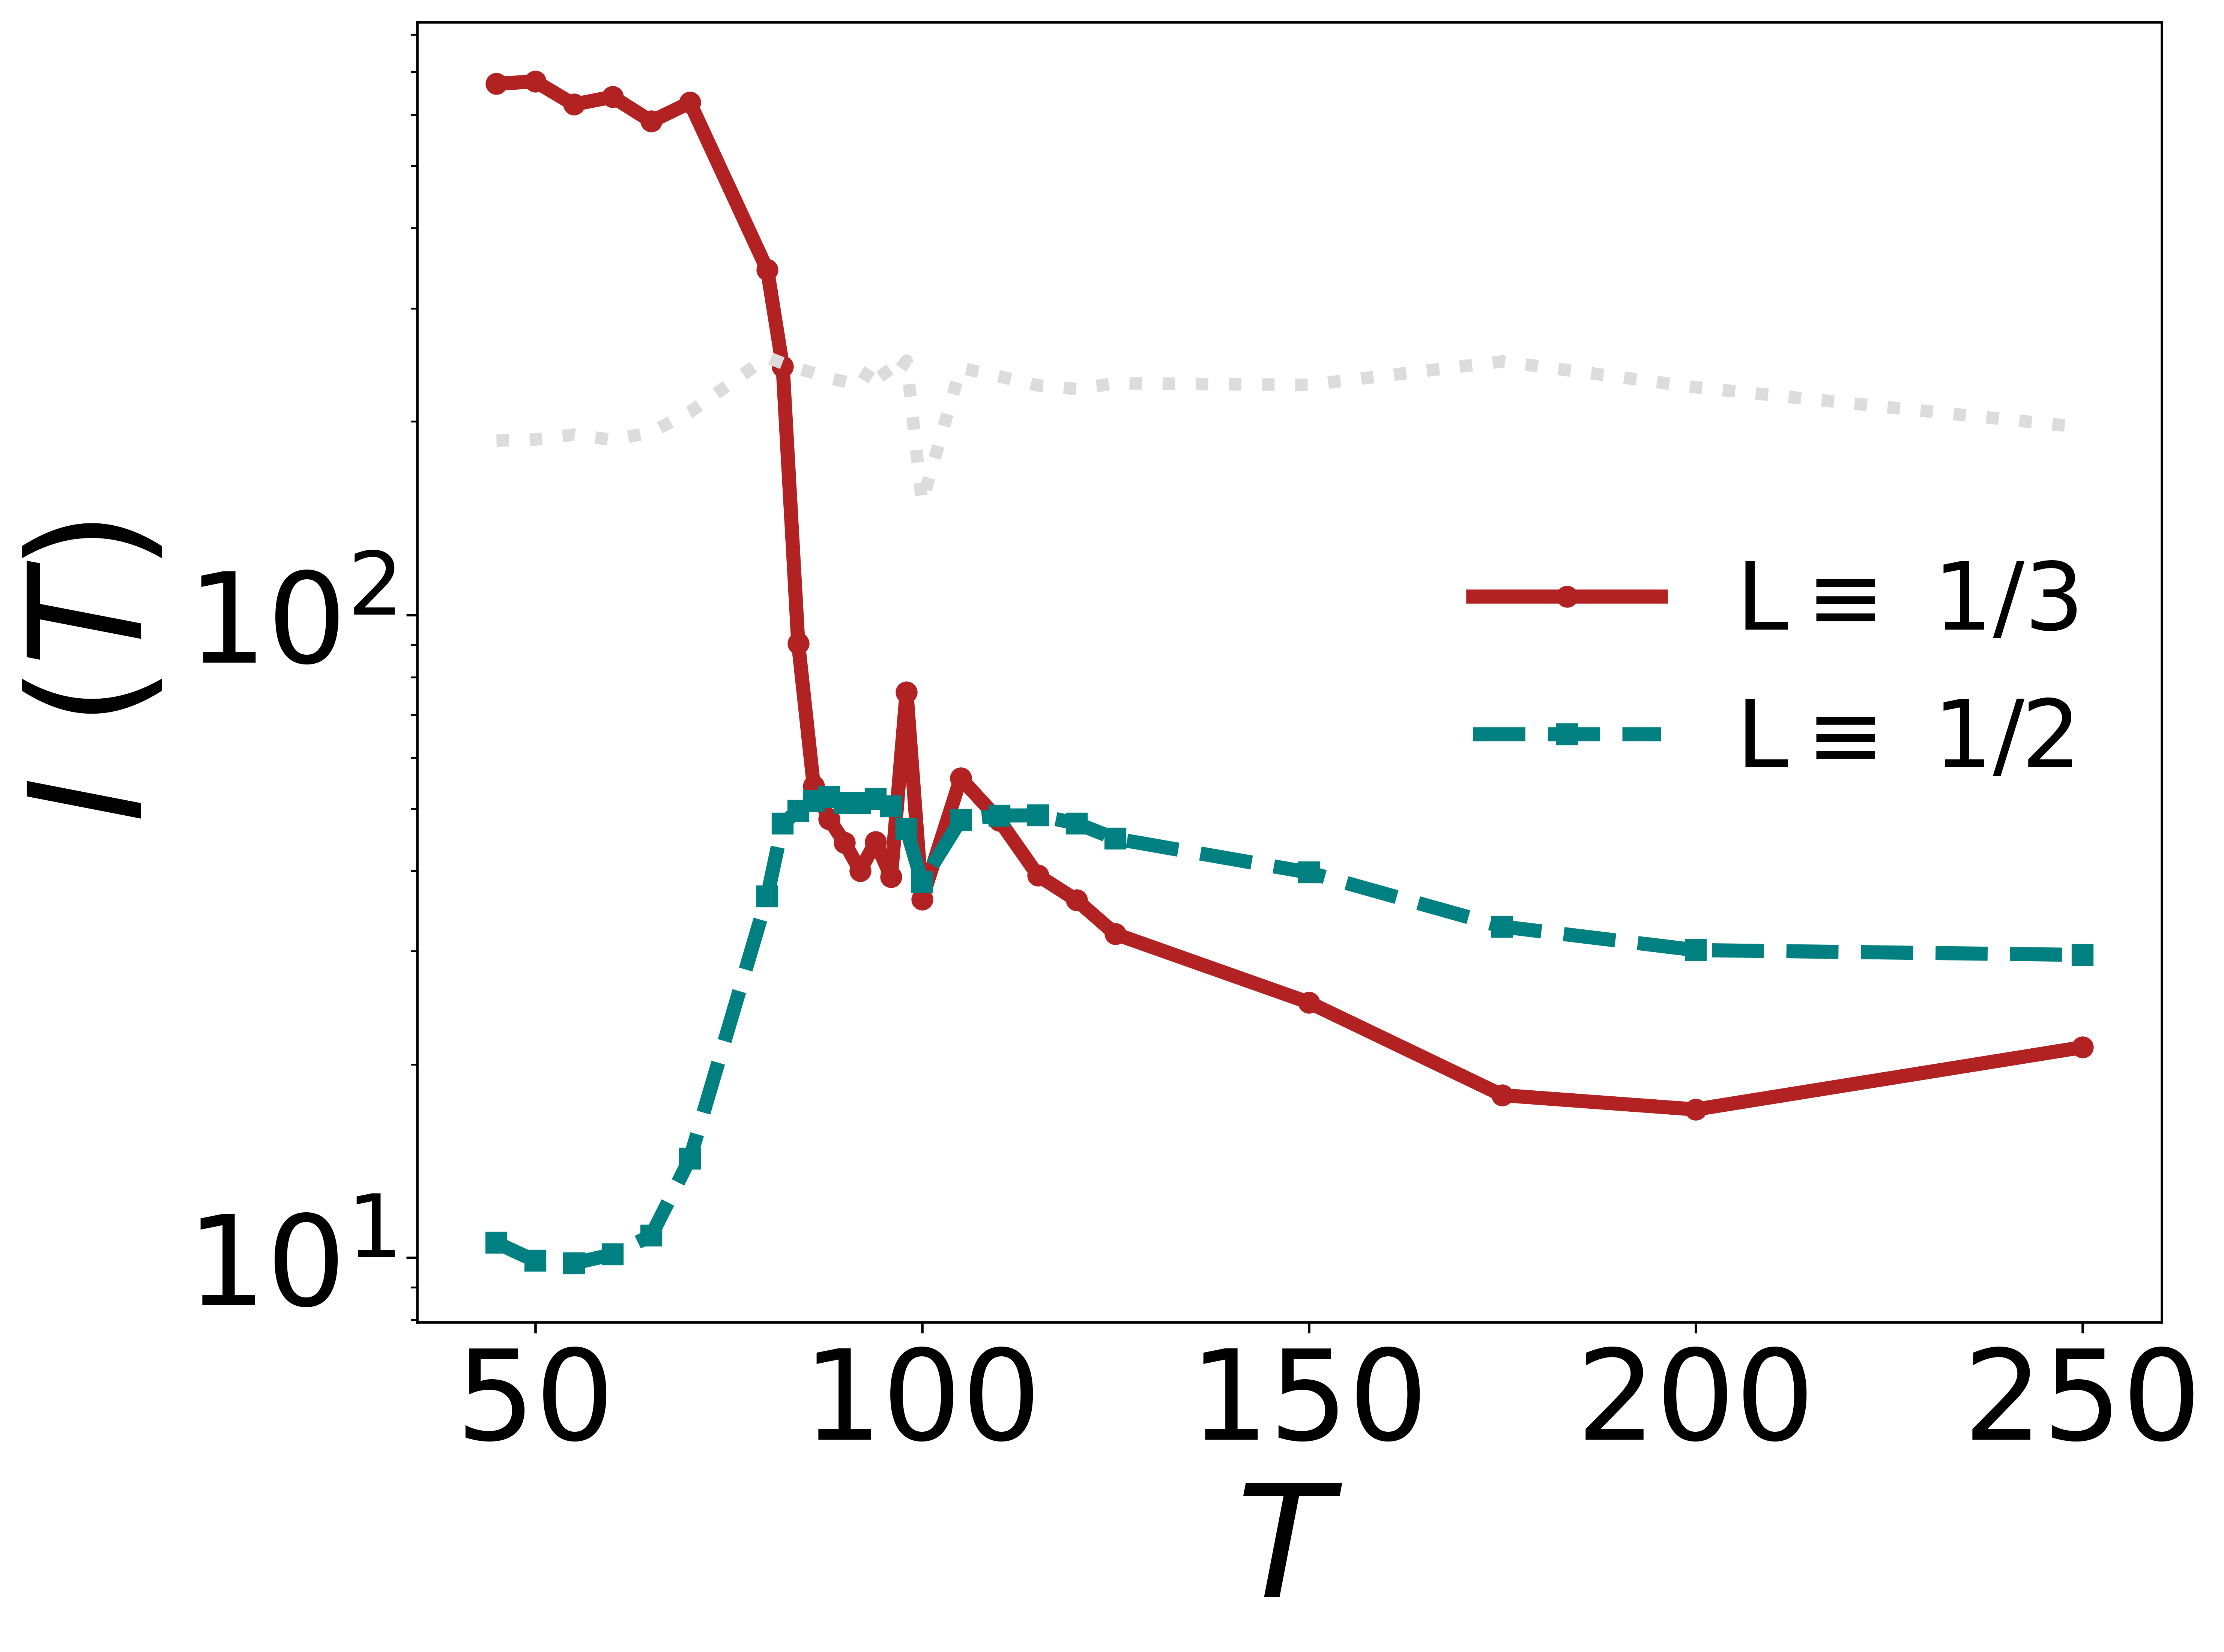

In [54]:
I_cluster_avg=[]


plt.figure(figsize=(10,7.5),dpi=600)
legends=[r'L$\equiv$ 1/3',r'L$\equiv$ 1/2',None]*5
for i in (range(n_clusters)):

    yc=np.mean(XTEC_D_data[:,cluster_assigns==i],axis=1)
    I_cluster_avg.append(yc)

    plt.plot(Tlist,yc,color=color_list[i], linestyle=line_list[i],marker=marker_list[i],lw=lw_list[i],label=legends[i]);
    
    
plt.xlabel(f'$T$',size=50)
plt.ylabel(r'$I$ ($T$)',size=50)
#plt.title(r'Average cluster intensity',size=50)
plt.legend(fontsize=30,frameon=False)
plt.yscale('log')

plt.xticks(size=40);
plt.yticks(size=40);


# Store data for plots

In [59]:
Plot_data={}
Plot_data['Temp']=np.array(Tlist)
Plot_data['Qh_Qk_Ql']= [Qh,Qk,Ql]

Plot_data['n_clusters']=n_clusters
Plot_data['rescaled_I_mean'] = cluster_mean
Plot_data['rescaled_I_std'] = cluster_std
Plot_data['Average_I'] = I_cluster_avg
Plot_data['Q_1BZ']=[H_BZ,K_BZ,L_BZ]



import pickle
pickle.dump( Plot_data, open( "ScV6Sn6_XTEC_plot_data.p", "wb" ) )
